This notebook is work in progress - Shows how to apply Bagging Optimized DMD (BOPDMD) to a 35 GB slice of ERA5.

In [15]:
import pickle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from svdrom.dask_utils import init_dask
from svdrom.dmd import OptDMD
from svdrom.io import open_dataarray
from svdrom.preprocessing import StandardScaler, variable_spatial_stack
from svdrom.svd import TruncatedSVD

In [ ]:
client = init_dask(dashboard=True)

[proxy.py:85 -             <module>() ] To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
[scheduler.py:1766 -             __init__() ] State start
[scheduler.py:4282 -         start_unsafe() ]   Scheduler at: inproc://10.100.0.2/79368/1
[scheduler.py:4297 -         start_unsafe() ]   dashboard at:  http://10.100.0.2:8787/status
[scheduler.py:8182 - register_worker_plugin() ] Registering Worker plugin shuffle
[worker.py:1457 -         start_unsafe() ]       Start worker at: inproc://10.100.0.2/79368/4
[worker.py:1458 -         start_unsafe() ]          Listening to:           inproc10.100.0.2
[worker.py:1461 -         start_unsafe() ]           Worker name:                          0
[worker.py:1463 -         start_unsafe() ]          dashboard at:           10.100.0.2:64584
[worker.py:1464 -         start_unsafe() ] Waiting to connect to: inproc://10.100.0.2/79368/1
[worker.py:1465 -         start_unsafe() ] ----

[_scheduler_plugin.py:214 -              _create() ] Shuffle 7a87bf75c340c1e6979f73ed48ab4d9a initialized by task ('reshape-sub-transpose-rechunk-transfer-8a13e1b8b04518d29b95681868a03fdb', 0, 0, 0, 99) executed on worker inproc://10.100.0.2/79368/4
[_scheduler_plugin.py:541 -  _clean_on_scheduler() ] Shuffle 7a87bf75c340c1e6979f73ed48ab4d9a deactivated due to stimulus 'task-finished-1760103790.728242'
[core.py:608 -        _measure_tick() ] Event loop was unresponsive in Worker for 5.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
[core.py:608 -        _measure_tick() ] Event loop was unresponsive in Scheduler for 5.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
[scheduler.py:6004 -        remove_client() ] Remove client Client-65474e48-a5de-11f0-b608-3b88f214e848
[core.py:908 -        handle_stream() ] Rec

In [3]:
era5_path = "data/era5_slice.zarr"
X = open_dataarray(era5_path)

2025-10-10 14:38 - I/O - INFO - Opening Xarray.DataArray from data/era5_slice.zarr.
[io.py:68 -       open_dataarray() ] Opening Xarray.DataArray from data/era5_slice.zarr.


In [4]:
X

<xarray.DataArray 'temperature' (time: 8766, latitude: 721, longitude: 1440)> Size: 36GB
dask.array<open_dataset-temperature, shape=(8766, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B ...
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

In [5]:
scaler = StandardScaler()
X = scaler(X)

2025-10-10 14:39 - Preprocessing - INFO - Computing mean along dimension time...
[preprocessing.py:124 -             __call__() ] Computing mean along dimension time...
2025-10-10 14:39 - Preprocessing - INFO - Finished computing mean.
[preprocessing.py:127 -             __call__() ] Finished computing mean.


In [6]:
X

<xarray.DataArray 'temperature' (time: 8766, latitude: 721, longitude: 1440)> Size: 36GB
dask.array<sub, shape=(8766, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B 500

In [7]:
X = variable_spatial_stack(X, dims=("latitude", "longitude"))

2025-10-10 14:40 - Preprocessing - INFO - Performing spatial stacking.
[preprocessing.py:55 - variable_spatial_stack() ] Performing spatial stacking.


In [8]:
X

<xarray.DataArray 'temperature' (time: 8766, samples: 1038240)> Size: 36GB
dask.array<reshape, shape=(8766, 1038240), dtype=float32, chunksize=(32, 1038240), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
  * samples    (samples) object 8MB MultiIndex
    level      int64 8B 500
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

In [9]:
X = X.T

In [10]:
X

<xarray.DataArray 'temperature' (samples: 1038240, time: 8766)> Size: 36GB
dask.array<transpose, shape=(1038240, 8766), dtype=float32, chunksize=(1038240, 32), chunktype=numpy.ndarray>
Coordinates:
  * samples    (samples) object 8MB MultiIndex
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
    level      int64 8B 500
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

In [11]:
rand_svd = TruncatedSVD(
    n_components=40,
    algorithm="randomized",
    rechunk=True,
    compute_var_ratio=True,
)

In [12]:
rand_svd.fit(X, n_power_iter=2, n_oversamples=15)

2025-10-10 14:41 - SVD - INFO - Will use randomized algorithm.
[svd.py:246 -                  fit() ] Will use randomized algorithm.
2025-10-10 14:41 - SVD - INFO - The input array is considered tall-and-skinny. Will rechunk the array before fitting the SVD. This will add some overhead.
[svd.py:142 -       _rechunk_array() ] The input array is considered tall-and-skinny. Will rechunk the array before fitting the SVD. This will add some overhead.
2025-10-10 14:41 - SVD - INFO - Computing SVD results...
[svd.py:267 -                  fit() ] Computing SVD results...
2025-10-10 14:45 - SVD - INFO - Done.
[svd.py:270 -                  fit() ] Done.


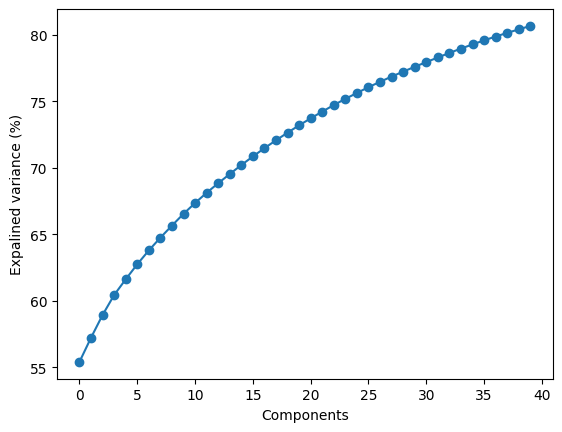

In [13]:
plt.plot(np.cumsum(rand_svd.explained_var_ratio)*100, "o-")
plt.xlabel("Components")
plt.ylabel("Expalined variance (%)")
plt.show()

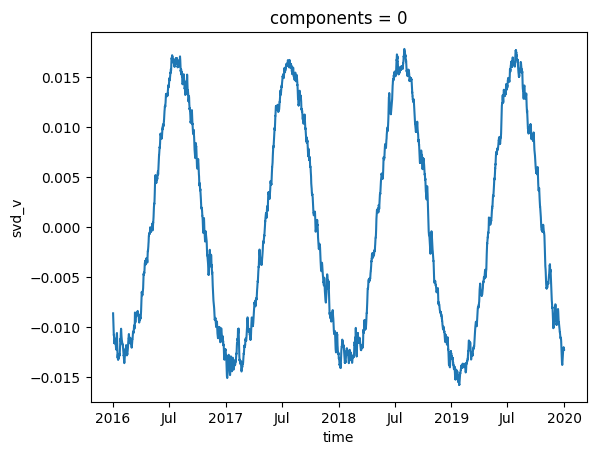

In [14]:
rand_svd.v[0, :].plot()
plt.show()

In [21]:
client.close()

[worker.py:1561 -                close() ] Stopping worker at inproc://10.100.0.2/79368/4. Reason: worker-close
[worker.py:1901 -        plugin_remove() ] Removing Worker plugin shuffle


In [20]:
with open("data/results/rand_svd_results.pkl", "wb") as f:
    pickle.dump(rand_svd, f)

with open("data/results/standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
client = init_dask(dashboard=True, processes=True)

[scheduler.py:1766 -             __init__() ] State start
[scheduler.py:4282 -         start_unsafe() ]   Scheduler at:     tcp://127.0.0.1:64865
[scheduler.py:4297 -         start_unsafe() ]   dashboard at:  http://127.0.0.1:8787/status
[scheduler.py:8182 - register_worker_plugin() ] Registering Worker plugin shuffle
[nanny.py:368 -         start_unsafe() ]         Start Nanny at: 'tcp://127.0.0.1:64868'
[nanny.py:368 -         start_unsafe() ]         Start Nanny at: 'tcp://127.0.0.1:64870'
[nanny.py:368 -         start_unsafe() ]         Start Nanny at: 'tcp://127.0.0.1:64872'
[nanny.py:368 -         start_unsafe() ]         Start Nanny at: 'tcp://127.0.0.1:64874'
[nanny.py:368 -         start_unsafe() ]         Start Nanny at: 'tcp://127.0.0.1:64876'
[scheduler.py:4635 -           add_worker() ] Register worker addr: tcp://127.0.0.1:64880 name: 4
[scheduler.py:6224 -        handle_worker() ] Starting worker compute stream, tcp://127.0.0.1:64880
[core.py:883 -        handle_stream()

[core.py:893 -        handle_stream() ] Connection to tcp://127.0.0.1:64892 has been closed.
[scheduler.py:5445 -        remove_worker() ] Remove worker addr: tcp://127.0.0.1:64882 name: 0 (stimulus_id='handle-worker-cleanup-1760104939.2303941')
[scheduler.py:5528 -        remove_worker() ] Removing worker 'tcp://127.0.0.1:64882' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'_run_trial-ba8ae854-2c73-4436-8ae3-c6e1bb74f6f7', '_run_trial-cd1a9de9-a3e8-473a-8dc4-1aa1057fec65', '_run_trial-9b0ce041-c44e-4ef9-b23a-f0556588d671', '_run_trial-e4d62107-695c-4f7a-9eb2-8b22ee6f6759'} (stimulus_id='handle-worker-cleanup-1760104939.2303941')
[nanny.py:593 -     close_gracefully() ] Closing Nanny gracefully at 'tcp://127.0.0.1:64868'. Reason: worker-handle-scheduler-connection-broken
[scheduler.py:4423 -     heartbeat_worker() ] Received heartbeat from unregistered worker 'tcp://127.0.0.1:64882'.
[nanny.py:611 -                close() ] Closing Nanny at 

In [23]:
optdmd = OptDMD(
    time_units="h",
    num_trials=50,
    trial_size=0.8,
    parallel_bagging=True,
)

In [24]:
%%time
optdmd.fit(
    rand_svd.u,
    rand_svd.s,
    rand_svd.v,
)

2025-10-10 14:55 - DMD - INFO - Computing the DMD fit...
[dmd.py:392 -                  fit() ] Computing the DMD fit...
2025-10-10 14:55 - DMD - INFO - Bagging will be performed in parallel.
[dmd.py:396 -                  fit() ] Bagging will be performed in parallel.
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/pydmd/bopdmd.py:996: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)
/Users/dsalvadorjasin/Documents/projects/svdrom/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 159.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more inf

Number of converged bags: 0 out of 50. Consider loosening the tol requirements of the variable projection routine.


2025-10-10 15:13 - DMD - INFO - Done.
[dmd.py:408 -                  fit() ] Done.


CPU times: user 3min 28s, sys: 1min 37s, total: 5min 5s
Wall time: 18min 9s


In [30]:
with open("data/results/opt_dmd_results.pkl", "wb") as f:
    pickle.dump(optdmd, f)

In [39]:
client.close()

In [ ]:
modes = optdmd.modes.unstack()
modes_std = optdmd.modes_std.unstack()

In [ ]:
# sort the modes in order of decreasing amplitude
mode_order = np.argsort(-np.abs(optdmd.amplitudes))
print(mode_order)

[21 18  9 30 16 23 19 20 15 24 37  2 27 12 13 26 29 10 32  7 25 14 11 28
  5 34 38  1 35  4 36  3  0 39  6 33 31  8 17 22]


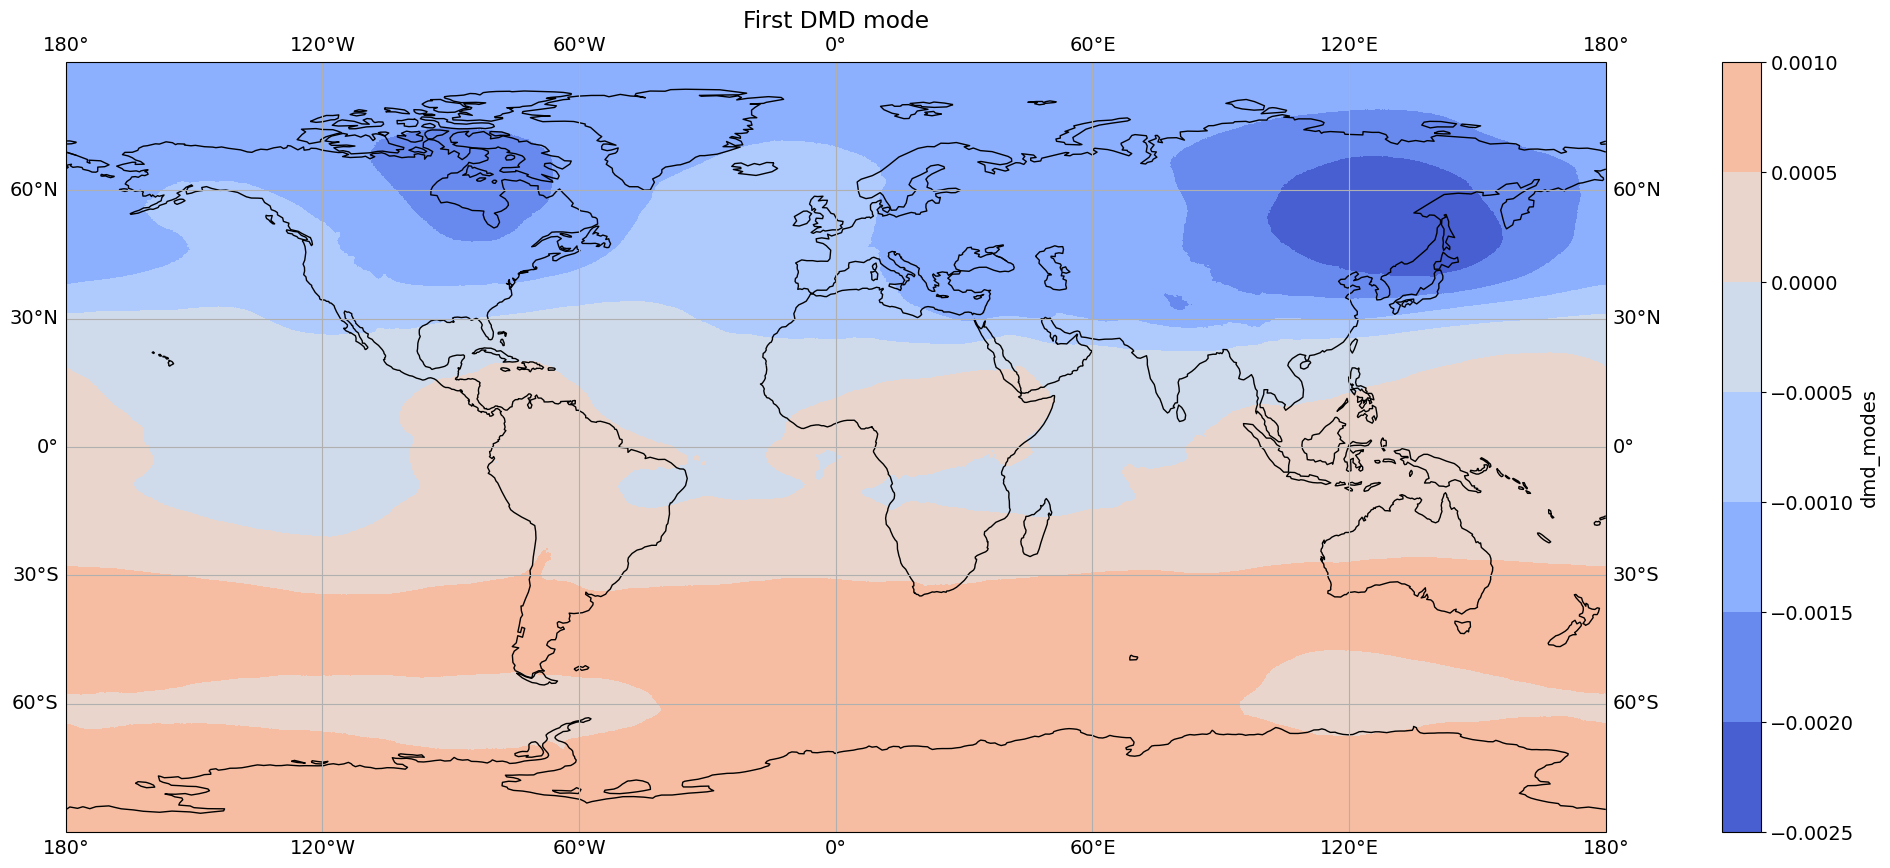

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

modes[mode_order[0], :, :].real.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm',
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)

plt.title("First DMD mode")
plt.show()

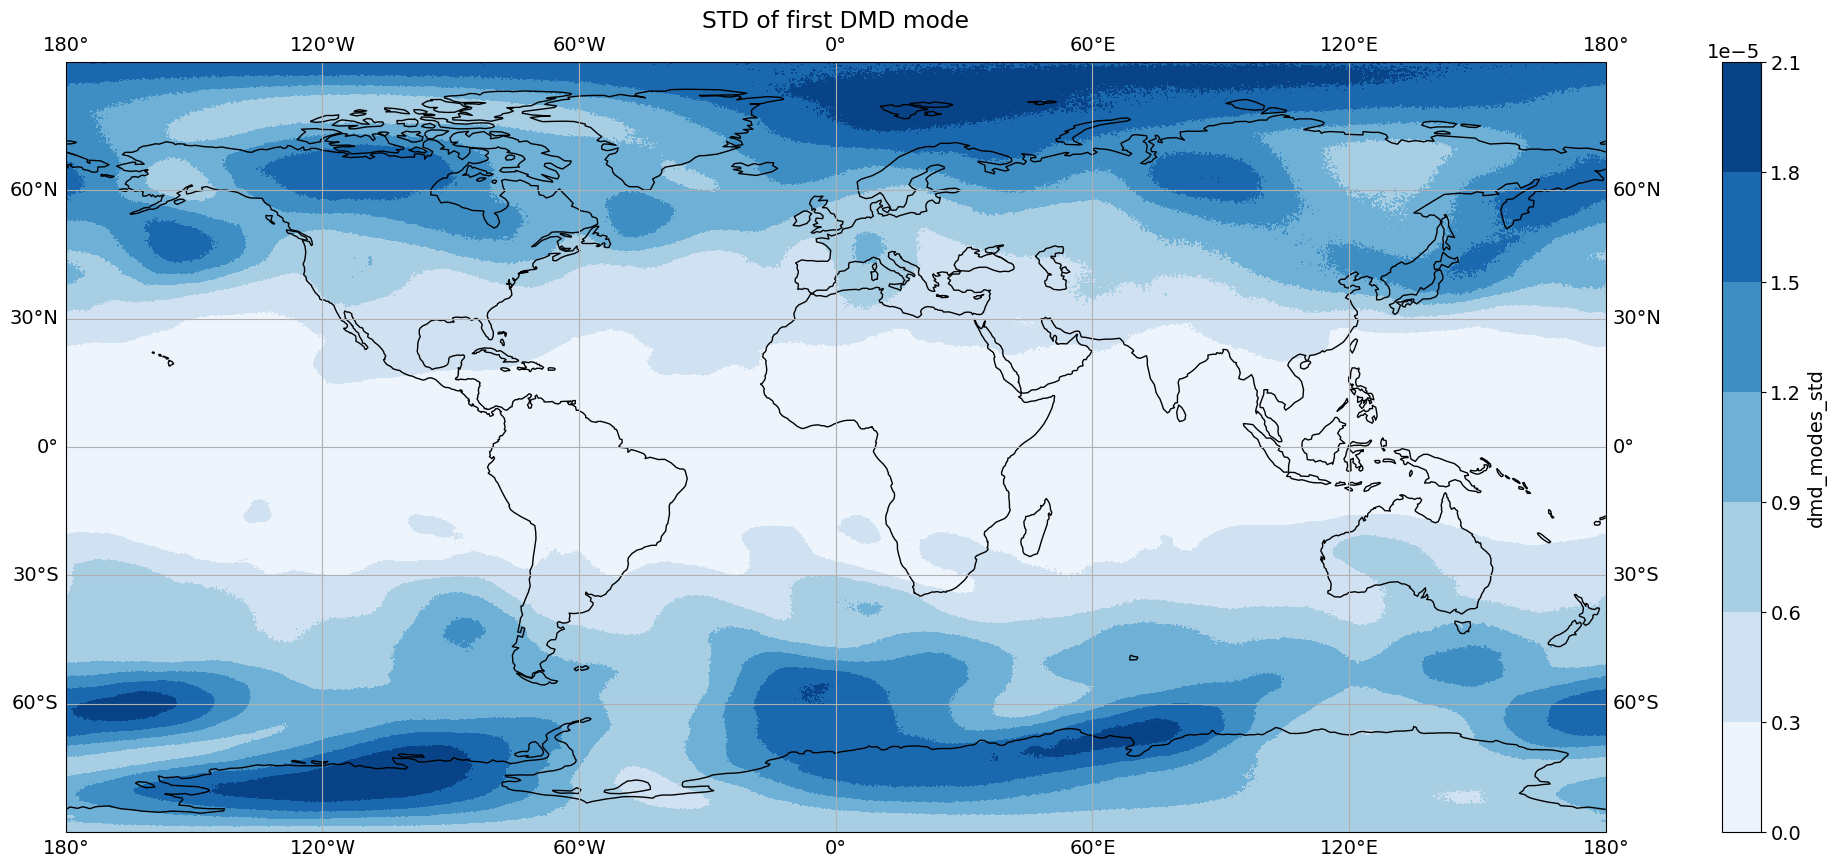

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

modes_std[mode_order[0], :, :].real.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='Blues',
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)

plt.title("STD of first DMD mode")
plt.show()

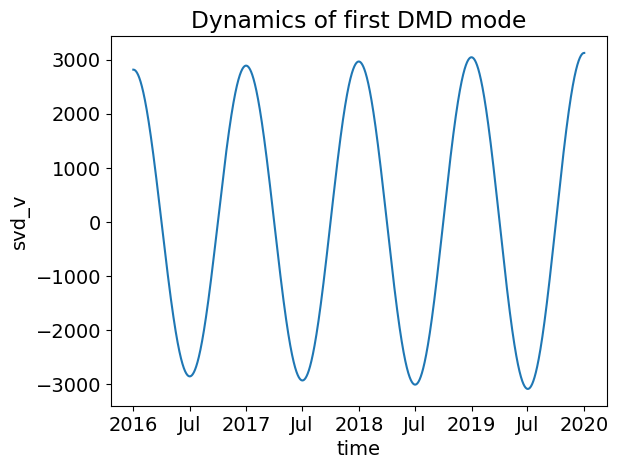

In [37]:
optdmd.dynamics[mode_order[0], :].real.plot()
plt.title("Dynamics of first DMD mode")
plt.show()

In [ ]:
# reconstruct the training data between 1st Dec 2019 and 31st Dec 2019
recon_mean, recon_var = optdmd.reconstruct(t=slice("2019-12-01", "2019-12-31"))

2025-10-10 15:57 - DMD - INFO - Estimated reconstruction size is 3089802.240 KB.
[dmd.py:731 -          reconstruct() ] Estimated reconstruction size is 3089802.240 KB.
2025-10-10 15:57 - DMD - INFO - Will use Dask to compute the reconstruction.
[dmd.py:734 -          reconstruct() ] Will use Dask to compute the reconstruction.
2025-10-10 15:57 - DMD - INFO - Computing the DMD reconstruction...
[dmd.py:740 -          reconstruct() ] Computing the DMD reconstruction...
2025-10-10 15:57 - DMD - INFO - Done.
[dmd.py:747 -          reconstruct() ] Done.


In [43]:
recon_mean = recon_mean.unstack()

In [44]:
recon_mean

<xarray.DataArray 'dmd_prediction_mean' (time: 186, latitude: 721,
                                         longitude: 1440)> Size: 3GB
dask.array<reshape, shape=(186, 721, 1440), dtype=complex128, chunksize=(186, 69, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1kB 2019-12-01 ... 2019-12-31T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B 500

In [45]:
scaler.mean

<xarray.DataArray 'temperature' (latitude: 721, longitude: 1440)> Size: 4MB
array([[239.87871, 239.87871, 239.87871, ..., 239.87871, 239.87871,
        239.87871],
       [239.89163, 239.89168, 239.89174, ..., 239.89145, 239.89151,
        239.89157],
       [239.90825, 239.90834, 239.90845, ..., 239.90794, 239.90802,
        239.90814],
       ...,
       [233.31805, 233.31706, 233.31606, ..., 233.32108, 233.32007,
        233.31909],
       [233.32436, 233.32385, 233.32333, ..., 233.32582, 233.32533,
        233.32484],
       [233.33545, 233.33545, 233.33545, ..., 233.33545, 233.33545,
        233.33545]], shape=(721, 1440), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B 500

In [46]:
recon_mean = recon_mean + scaler.mean

In [47]:
recon_mean = recon_mean.compute()

In [48]:
recon_mean

<xarray.DataArray (time: 186, latitude: 721, longitude: 1440)> Size: 3GB
array([[[230.00269684+0.32716349j, 230.00269705+0.32716348j,
         230.00269695+0.32716348j, ..., 230.00269691+0.32716349j,
         230.00269691+0.32716349j, 230.00269691+0.32716349j],
        [230.38358084+0.30528133j, 230.36124605+0.329477j  ,
         230.4170195 +0.3403806j , ..., 230.1864029 +0.3530463j ,
         230.31114176+0.32780346j, 230.49706348+0.34192967j],
        [230.29547874+0.34848757j, 230.18360863+0.33634587j,
         230.32769299+0.35495549j, ..., 230.50984639+0.34908736j,
         230.58905191+0.36473159j, 230.47796388+0.38035191j],
        ...,
        [236.04744638-0.0862773j , 236.16712791-0.08376979j,
         236.16786432-0.07895915j, ..., 236.26713038-0.07482973j,
         236.03785267-0.07794194j, 235.98698643-0.06449501j],
        [236.0248093 -0.07324421j, 236.08092005-0.08655668j,
         235.87189337-0.07690957j, ..., 236.02861705-0.08053482j,
         236.11341219-0.08722916j, 236.09120057-0.07705393j],
        [236.0935671 -0.0862547j , 236.0935671 -0.0862547j ,
         236.0935671 -0.0862547j , ..., 236.09275481-0.08589619j,
         236.09275481-0.08589619j, 236.09275481-0.08589619j]],

...
       [[230.73529998-0.27148572j, 230.73529995-0.27148571j,
         230.73529992-0.27148571j, ..., 230.73529979-0.27148572j,
         230.73529979-0.27148572j, 230.73529979-0.27148572j],
        [231.00046127-0.21960876j, 230.92479489-0.23647111j,
         230.75375169-0.23451273j, ..., 230.75653126-0.27803962j,
         230.94894785-0.24317573j, 230.84092445-0.24224845j],
        [230.67631923-0.25953568j, 230.84417738-0.25800349j,
         230.81473437-0.2772946j , ..., 230.6437457 -0.24509098j,
         230.80979021-0.26486028j, 230.6726279 -0.27841544j],
        ...,
        [237.84163811+0.15124302j, 237.93528657+0.15146479j,
         237.77575608+0.15366916j, ..., 237.84998532+0.14552254j,
         237.77250445+0.14151981j, 237.7324834 +0.1239693j ],
        [237.59207796+0.14875872j, 237.71005837+0.16011181j,
         237.5904919 +0.1401239j , ..., 237.50328483+0.1589994j ,
         237.72206112+0.15350897j, 237.6033142 +0.15173334j],
        [237.60772032+0.16372663j, 237.60772032+0.16372663j,
         237.60772032+0.16372663j, ..., 237.60329561+0.1636672j ,
         237.60329561+0.1636672j , 237.60329561+0.1636672j ]]],
      shape=(186, 721, 1440))
Coordinates:
  * time       (time) datetime64[ns] 1kB 2019-12-01 ... 2019-12-31T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B 500

In [ ]:
X = X.unstack()
X = X + scaler.mean

In [53]:
X

<xarray.DataArray 'temperature' (time: 8766, latitude: 721, longitude: 1440)> Size: 36GB
dask.array<add, shape=(8766, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2019-12-31T20:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    level      int64 8B 500

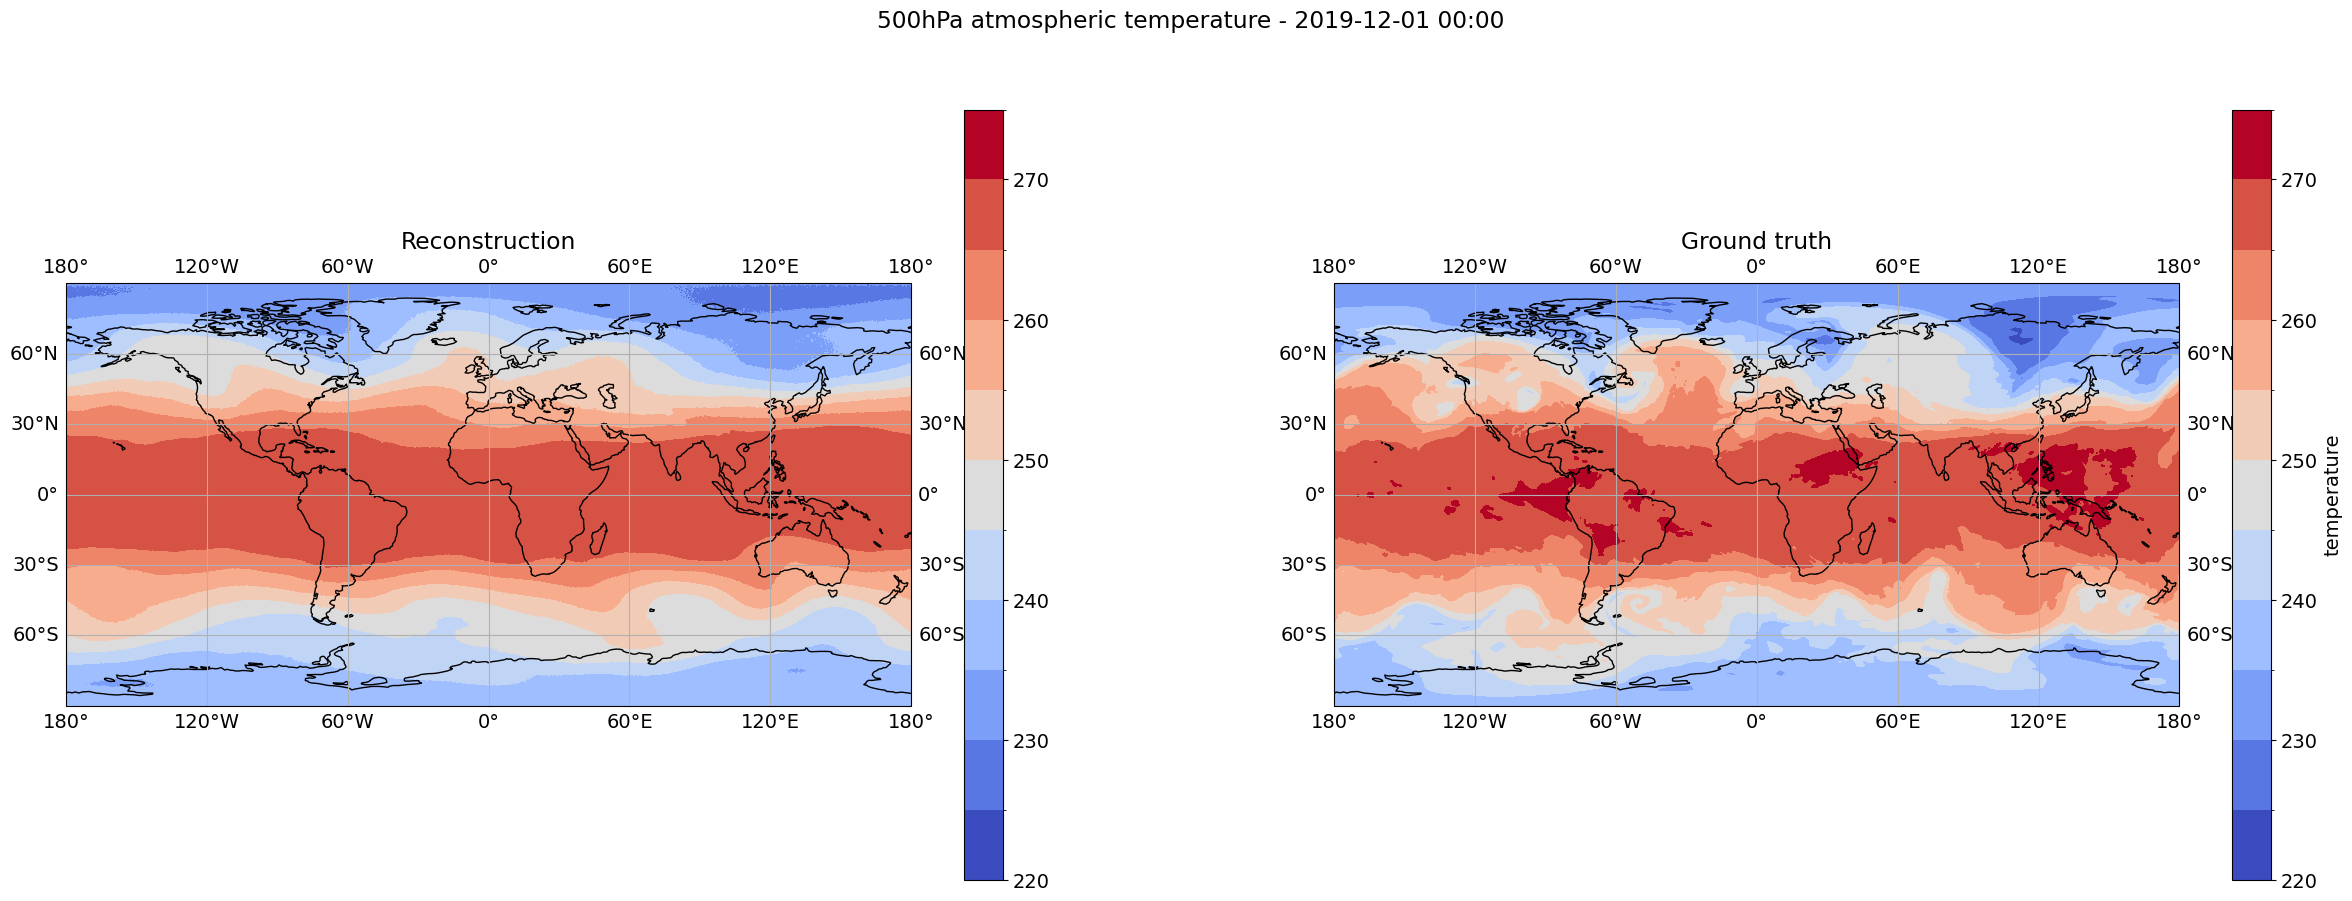

In [63]:
fig, axs = plt.subplots(
    1, 2, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()}
)

ax = axs[0]
recon_mean.sel(time="2019-12-01T00:00").real.plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=range(220, 280, 5)
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)
ax.set_title("Reconstruction")

ax = axs[1]
X.sel(time="2019-12-01T00:00").plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=range(220, 280, 5)
)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True)
ax.set_title("Ground truth")

fig.suptitle("500hPa atmospheric temperature - 2019-12-01 00:00")
plt.show()